# MetaChat analysis on spatial multi-omics data of mouse brain with Parkinson's disease

In this tutorial, we use mouse brain slices as an example to show the basic application of MetaChat to multi-omics data of transcriptomics and metabolomics [[Marco et al., 2023](https://www.nature.com/articles/s41587-023-01937-y)].

In [ ]:
# Importing packages
import os
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

In [ ]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main/")
import metachat as mc

## Import dataset

In [4]:
adata = sc.read('datasets/mouse_brain_parkinson/adata_combined.h5ad')

The spatial distribution of tissue types reveals well-defined anatomical layers and regions in the mouse brain section.

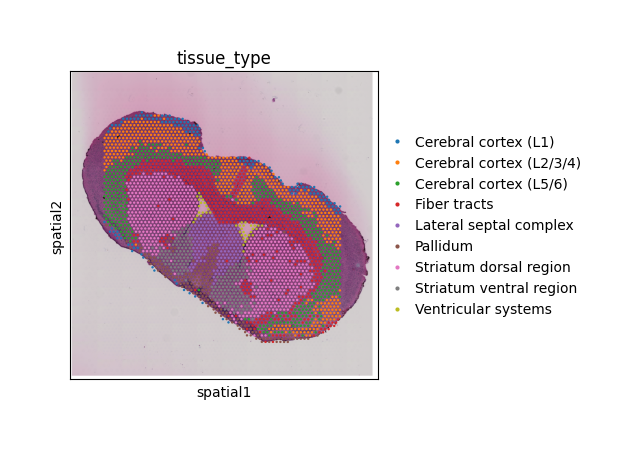

In [5]:
fig, ax = plt.subplots(figsize = (4,4))
sq.pl.spatial_scatter(adata = adata,
                      color = "tissue_type",
                      ax = ax)
ax.set_box_aspect(1)

## MCC Inference

### Import MetaChatDB

Load the curated MetaChat database containing metabolite–sensor interaction pairs for mouse (or human).

In [6]:
df_metasen = mc.pp.MetaChatDB(species='mouse') # If human, please input species='human'.

### Identify long-range channels (LRCs)

In this example, prior anatomical knowledge suggests that the Fiber tracts region is likely to intersect with cerebrospinal fluid (CSF) pathways. Therefore, the spots clustered as fiber tracts are manually annotated as candidate points.

In [8]:
LRC_name = "CSF"
adata.obs['LRC_' + LRC_name + '_manual_unfiltered'] = ((adata.obs['tissue_type'] == 'Fiber tracts')).astype(int)

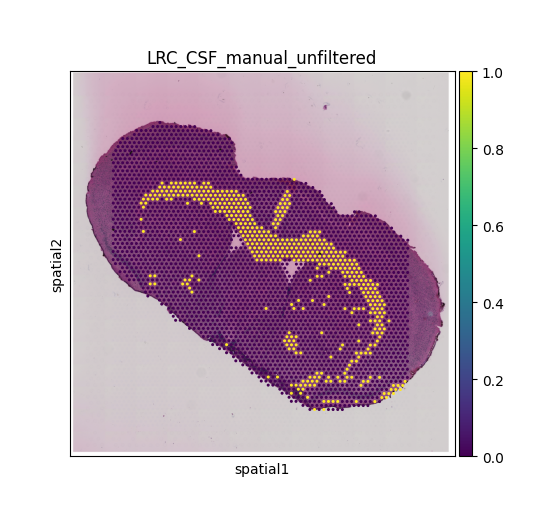

In [9]:
fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'LRC_' + LRC_name + '_manual_unfiltered',
                      ax = ax)
ax.set_box_aspect(1)

Next, we performed density-based clustering on the manually annotated CSF candidate points to identify coherent LRC regions.

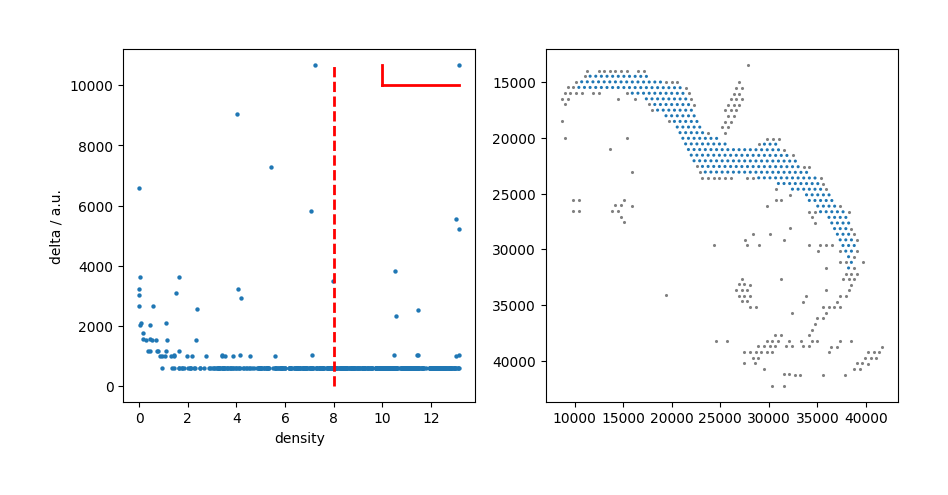

In [10]:
LRC_cluster_CSF = mc.pp.LRC_cluster(adata = adata,
                                    LRC_name = LRC_name,
                                    LRC_source = "manual",
                                    density_cutoff = 10,
                                    delta_cutoff = 10000,
                                    outlier_cutoff = 8)

Then, the `mc.pp.LRC_filtered()` function was executed to remove outlier points from the clustered CSF LRC candidates, and the filtered LRCs were stored in adata.obs['LRC_CSF_manual_filtered'].

In [11]:
mc.pp.LRC_filtered(adata = adata,
                   LRC_name = LRC_name,
                   LRC_cluster = LRC_cluster_CSF,
                   LRC_source = "manual")

Candidate points for CSF LRC are clustered and outliers are removed. LRC points are stored in 'adata.obs['LRC_CSF_manual_filtered']'.


/home/project/metachat_packages/MetaChat-main/metachat_new/preprocessing/_identifyLRC.py:245: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[key_filtered][adata.obs[key_filtered] == 1] = newcluster
/home/project/metachat_packages/Me

Since CSF mainly flows within the ventricular systems, we also marked this region as part of the LRCs.

In [12]:
adata.obs['LRC_CSF_manual_filtered'] = (
    adata.obs['LRC_CSF_manual_filtered'].astype(int) | 
    (adata.obs['tissue_type'] == 'Ventricular systems').astype(int)
).astype('category')

Then, we can visualize the determined LRC.

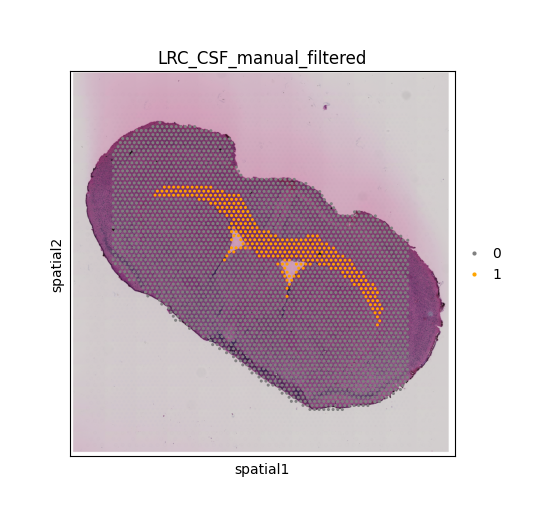

In [13]:
# Set color for LRCs
adata.obs['LRC_CSF_manual_filtered'] = adata.obs['LRC_CSF_manual_filtered'].astype('category')
adata.uns['LRC_CSF_manual_filtered' + '_colors'] = ['gray', 'orange']

fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_manual_filtered',
                      alpha = 1,
                      ax = ax)
ax.set_box_aspect(1)

### Compute cost distance

After identifying the LRCs, we compute the cost between any pair of points. In general, the cost is determined by the Euclidean distance; however, when LRCs and anatomical barriers are considered, the cost is redefined based on these additional constraints.

The parameter `dis_thr` is critical for defining how far a metabolite signal is assumed to propagate. Since the spatial scale of coordinates varies across datasets, it is important to visually inspect and adjust `dis_thr`. The function `mc.pl.plot_dis_thr` allows users to visualize this threshold by specifying the distance (`dis_thr`) and the central spot (spot_index), enabling intuitive calibration of the propagation range. Here we use `dis_thr=2500`.

<Axes: title={'center': 'Spots within dis_thr=2500 of spot 1444'}, xlabel='spatial1', ylabel='spatial2'>

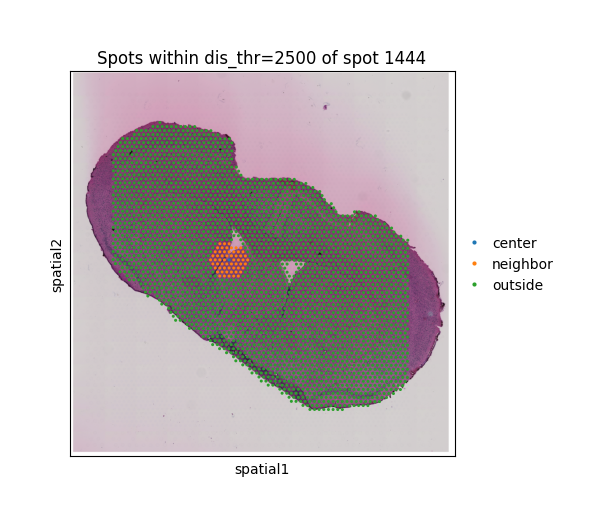

In [14]:
dis_thr = 2500
mc.pl.plot_dis_thr(adata = adata, dis_thr = dis_thr, spot_index = 1444)

The function mc.pp.compute_costDistance() calculates the spatial cost distance matrix between all spots, integrating both Euclidean proximity and long-range channel (LRC) effects. Specifically, it adjusts the pairwise distances according to the defined `LRC_type` and their corresponding `LRC_strength`, allowing metabolite diffusion or communication along designated LRC paths to be modeled more realistically. 

The parameters `LRC_type` and `LRC_source` should correspond to the names used in adata.obs['LRC_<LRC_type>_<LRC_source>_filtered'].
A higher value of `LRC_strength` indicates a stronger influence of long-range communication, effectively expanding the propagation range through LRCs. The parameter `dis_thr` should match the distance threshold defined in the previous step.
We support and recommend setting `use_parallel = True` and increasing `n_jobs` within the limits of your system performance, as this can significantly accelerate the computation of the cost distance matrix. The resulting distance matrix is stored in adata.obsp (e.g., adata.obsp['spatial_distance_LRC_CSF']) and can be used in downstream analyses of metabolic cell communication.

In [15]:
mc.pp.compute_costDistance(
    adata = adata,
    LRC_type = ['CSF'],
    LRC_strength = [10],
    LRC_source = "manual",
    dis_thr = dis_thr,
    k_neighb = 5,
    use_parallel = True,
    n_jobs = 64
)

Computing baseline spatial distance without LRC.
  Barrier condition is not considered
Computing spatial distance with LRCs.
  Processing LRC type: CSF
    Constructing graph for each LRC subcluster.
    Computing shortest path between two points in CSF.
      For the cluster 1 in CSF.


100%|██████████| 318/318 [00:00<00:00, 778.71it/s]


    Incorporating LRC strength of 'CSF' into cost distance matrix (strength = 10).
adata.obsp['spatial_distance_LRC_CSF'] has been saved.
Finished!


In [17]:
adata

AnnData object with n_obs × n_vars = 3054 × 40235
    obs: 'in_tissue', 'array_row', 'array_col', 'tissue_type', 'LRC_CSF_manual_unfiltered', 'LRC_CSF_manual_filtered', 'LRC_CSF_closepoint_cluster1'
    uns: 'spatial', 'tissue_type_colors', 'LRC_CSF_manual_filtered_colors'
    obsm: 'spatial'
    obsp: 'spatial_distance_LRC_base', 'LRC_shortest_CSF_dist2500_cluster1', 'spatial_distance_LRC_CSF'

As shown, the distances from the central spot (`spot_index`) to the surrounding spots are markedly reduced near the LRC, since these locations lie along or close to the LRC and are therefore more likely to participate in long-range communication.

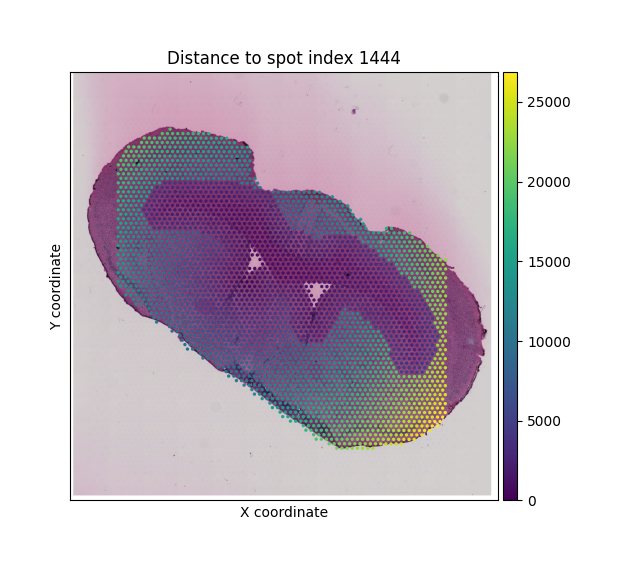

<Axes: title={'center': 'Distance to spot index 1444'}, xlabel='X coordinate', ylabel='Y coordinate'>

In [16]:
mc.pl.plot_spot_distance(adata = adata,
                         dist_matrix_key = 'spatial_distance_LRC_CSF',
                         spot_index = 1444)

We can visualize which spatial spots are influenced by the LRC.

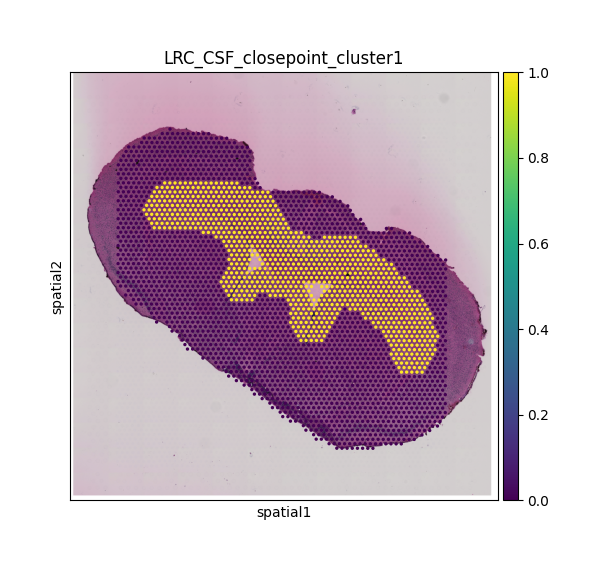

In [18]:
fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_closepoint_cluster1',
                      alpha = 1,
                      ax = ax)
ax.set_box_aspect(1)
ax.set_title('LRC_CSF_closepoint_cluster1')
plt.tight_layout()
plt.show()

The function `mc.tl.metabolic_communication` performs the inference of MCC based on spatial proximity and the selected metabolite–sensor interaction database.
Using the cost distance matrix and LRC information, it identifies potential sender–receiver pairs where metabolites can feasibly diffuse or be transported between spots within the defined distance threshold (`dis_thr`).
In this example, 517 metabolite–sensor pairs were detected from the spatial data using the MetaChatDB reference and the CSF-related LRC configuration.

In [19]:
mc.tl.metabolic_communication(adata = adata,
                              database_name = 'MetaChatDB',
                              df_metasen = df_metasen,
                              LRC_type = ["CSF"],
                              dis_thr = dis_thr)

There are 517 pairs were found from the spatial data.


For each metabolite–sensor pair, the inferred signaling strength between all spatial spots is stored as an `n_obs × n_obs` sparse matrix in `adata.obsp['MetaChat-MetaChatDB-sender-<metabolite>-<sensor>']` and `adata.obsp['MetaChat-MetaChatDB-receiver-<metabolite>-<sensor>']`, where each entry represents the potential communication intensity from a sender spot to a receiver spot.
Because transcriptomic (sensor) and metabolomic (metabolite) data are measured in different units, MetaChat provides two corresponding matrices — one for the `sender` (metabolite abundance) and one for the `receiver` (sensor expression).
Their relative values are consistent, but they differ in scale to reflect the distinct quantitative units of each modality.

In [21]:
adata

AnnData object with n_obs × n_vars = 3054 × 40235
    obs: 'in_tissue', 'array_row', 'array_col', 'tissue_type', 'LRC_CSF_manual_unfiltered', 'LRC_CSF_manual_filtered', 'LRC_CSF_closepoint_cluster1'
    uns: 'spatial', 'tissue_type_colors', 'LRC_CSF_manual_filtered_colors', 'df_metasen_filtered', 'MetaChat-MetaChatDB-info'
    obsm: 'spatial', 'MetaChat-MetaChatDB-sum-sender', 'MetaChat-MetaChatDB-sum-receiver'
    obsp: 'spatial_distance_LRC_base', 'LRC_shortest_CSF_dist2500_cluster1', 'spatial_distance_LRC_CSF', 'MetaChat-MetaChatDB-sender-HMDB0000045-Adora2a', 'MetaChat-MetaChatDB-receiver-HMDB0000045-Adora2a', 'MetaChat-MetaChatDB-sender-HMDB0000045-Slc25a17', 'MetaChat-MetaChatDB-receiver-HMDB0000045-Slc25a17', 'MetaChat-MetaChatDB-sender-HMDB0000045-Adora1', 'MetaChat-MetaChatDB-receiver-HMDB0000045-Adora1', 'MetaChat-MetaChatDB-sender-HMDB0000039-Ffar3', 'MetaChat-MetaChatDB-receiver-HMDB0000039-Ffar3', 'MetaChat-MetaChatDB-sender-HMDB0000039-Ffar2', 'MetaChat-MetaChatDB-receive

The matrices `adata.obsm['MetaChat–MetaChatDB–sum–sender']` and `adata.obsm['MetaChat–MetaChatDB–sum–receiver']` represent the total communication strength of each spot acting as a sender or receiver, respectively.
Technically, these values are obtained by summing the corresponding rows (for senders) and columns (for receivers) of each metabolite–sensor communication matrix, providing a global measure of how actively each spot participates in metabolite-mediated signaling.

In [20]:
adata.write('datasets/mouse_brain_parkinson/metachat_result.h5ad')